# Libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import issparse
from pathlib import Path
import scanpy as sc
import geopandas as gpd
from sklearn_ann.kneighbors.annoy import AnnoyTransformer
# to install %pip install -q "scanpy" "sklearn-ann[annoy]"
import matplotlib.pyplot as plt
import scanpy.external as sce
import random
import matplotlib.colors as mcolors
import pandas as pd
import seaborn as sns

In [2]:
segmentation_path = Path("/Users/janzules/Roselab/Spatial/CAR_T/data/cell_segmentation/")
adata_file     = segmentation_path / "concatenated" / "combined_adata.h5ad"
geneList = segmentation_path / "Gene_lists"
fig_out = Path("/Users/janzules/Roselab/Spatial/CAR_T/figures/clustering_results/")
ST_sample = sc.read_h5ad(adata_file)

## QC Figures

In [15]:
ST_sample.shape

(280933, 18928)

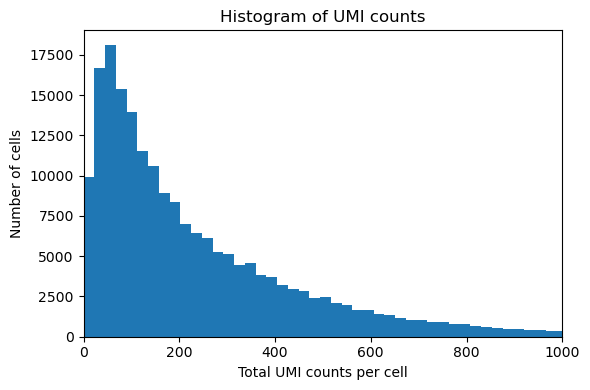

In [3]:
plt.figure(figsize=(6,4))
plt.hist(ST_sample.obs['total_counts'], bins=400)
# plt.yscale('log')              # log y‐axis to see the tail more clearly
plt.xlabel('Total UMI counts per cell')
plt.ylabel('Number of cells')
plt.title('Histogram of UMI counts')
plt.xlim(0, 1000) 
plt.tight_layout()
plt.show()

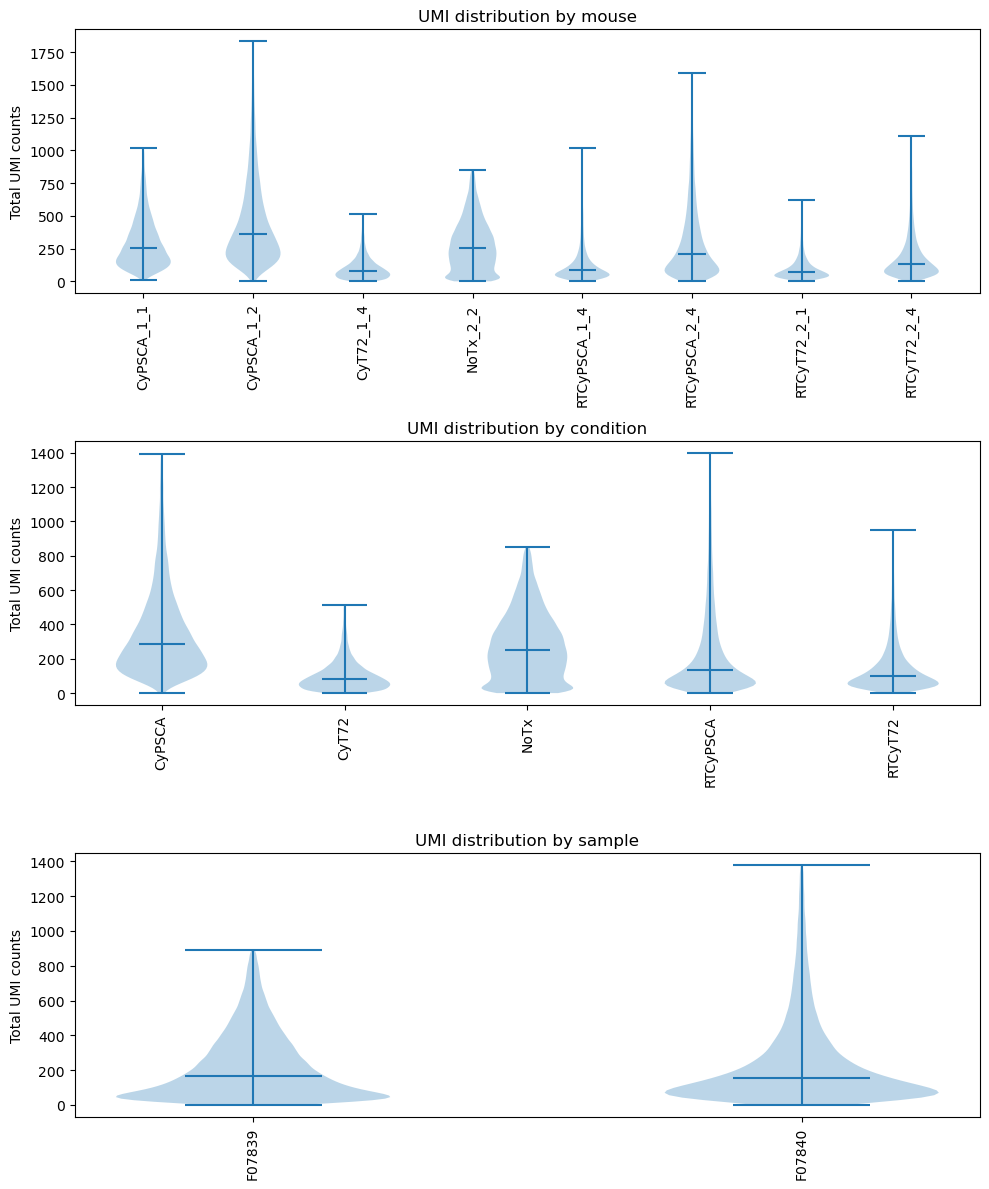

In [5]:
# Prepare filtered data to remove high outliers per group
# df = ST_sample.obs[['total_counts', 'mouse', 'condition', 'sample_id']].copy()
df = ST_sample.obs[['total_counts', 'mouse', 'condition', 'sample_id']].copy()

# Drop outliers per grouping level
def filter_outliers(group_col):
    thresholds = df.groupby(group_col, observed=False)['total_counts'].quantile(0.98)
    return df[df.apply(lambda row: row['total_counts'] <= thresholds[row[group_col]], axis=1)]

df_mouse = filter_outliers('mouse')
df_condition = filter_outliers('condition')
df_sample = filter_outliers('sample_id')

# Build subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharey=False)

# Panel 1: grouped by mouse
mouse_order = df_mouse['mouse'].cat.categories if df_mouse['mouse'].dtype.name == 'category' else sorted(df_mouse['mouse'].unique())
data_mouse = [df_mouse.loc[df_mouse['mouse'] == m, 'total_counts'] for m in mouse_order]
axes[0].violinplot(data_mouse, showmedians=True)
axes[0].set_xticks(range(1, len(mouse_order)+1))
axes[0].set_xticklabels(mouse_order, rotation=90)
axes[0].set_title('UMI distribution by mouse')

# Panel 2: grouped by condition
cond_order = df_condition['condition'].cat.categories if df_condition['condition'].dtype.name == 'category' else sorted(df_condition['condition'].unique())
data_condition = [df_condition.loc[df_condition['condition'] == c, 'total_counts'] for c in cond_order]
axes[1].violinplot(data_condition, showmedians=True)
axes[1].set_xticks(range(1, len(cond_order)+1))
axes[1].set_xticklabels(cond_order, rotation=90)
axes[1].set_title('UMI distribution by condition')

# Panel 3: grouped by sample_id
sample_order = df_sample['sample_id'].cat.categories if df_sample['sample_id'].dtype.name == 'category' else sorted(df_sample['sample_id'].unique())
data_sample = [df_sample.loc[df_sample['sample_id'] == s, 'total_counts'] for s in sample_order]
axes[2].violinplot(data_sample, showmedians=True)
axes[2].set_xticks(range(1, len(sample_order)+1))
axes[2].set_xticklabels(sample_order, rotation=90)
axes[2].set_title('UMI distribution by sample')

# Final formatting
for ax in axes:
    ax.set_ylabel('Total UMI counts')

plt.tight_layout()
plt.show()
